# Traduction de texte à l'aide de réseaux de neurones séquence à séquence

Dans les deux guides précédents, nous avons utilisé des réseaux de neurones pour classer du texte et effectuer une analyse des sentiments. Les deux tâches impliquent de prendre une entrée nlp et de prédire une certaine valeur. Dans le cas de notre analyse des sentiments, il s'agissait d'un nombre compris entre 0 et 1 représentant le sentiment de notre phrase. Dans le cas de notre modèle de classification de phrases, notre sortie était une prédiction multi-classe, dont il y avait plusieurs catégories auxquelles notre phrase appartenait. Mais que se passe-t-il si nous souhaitons faire non seulement une seule prédiction, mais prédire une phrase entière ? Dans ce guide, nous allons construire un modèle séquence à séquence qui prend une phrase dans une langue en entrée et génère la traduction de cette phrase dans une autre langue.


Nous avons déjà exploré plusieurs types d'architecture de réseau de neurones utilisés pour l'apprentissage de NLP, à savoir les réseaux de neurones récurrents, Réseaux de neurones récurrents et analyse des sentiments, et les réseaux de neurones convolutifs, Classification de texte à l'aide de CNN, nous utiliserons à nouveau ces RNN familiers, mais au lieu de simplement construire un modèle RNN simple, nous utiliserons les RNN dans le cadre d'un modèle plus vaste et plus complexe afin d'effectuer une traduction de séquence à séquence. En utilisant les fondements des RNN que nous avons appris dans les guide précédents, nous pouvons montrer comment ces concepts peuvent être étendus afin de créer une variété de modèles qui peuvent être adaptés à l'objectif.


Dans ce guide, nous aborderons les sujets suivants :
* La théorie des modèles séquence à séquence
* Construire un réseau de neurones séquence à séquence pour la traduction de texte

## Théorie des modèles séquence à séquence

Les modèles séquence à séquence sont très similaires aux structures de réseau neuronal . La principale différence est que pour la sortie d'un modèle, nous attendons une autre séquence, plutôt qu'une prédiction binaire ou multi-classe. Ceci est particulièrement utile dans des tâches telles que la traduction, où nous pouvons souhaiter convertir une phrase entière dans une autre langue.


Dans l'exemple suivant, nous pouvons voir que notre traduction de l'anglais vers l'espagnol correspond mot à mot :

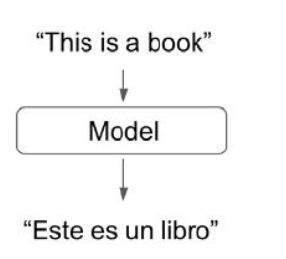


Le premier mot de notre phrase d'entrée correspond parfaitement au premier mot de notre phrase de sortie. Si c'était le cas pour toutes les langues, nous pourrions simplement passer chaque mot de notre phrase un par dans notre modèle entraîné pour obtenir une phrase de sortie, et il n'y aurait pas besoin de modélisation séquence à séquence, comme indiqué ici.

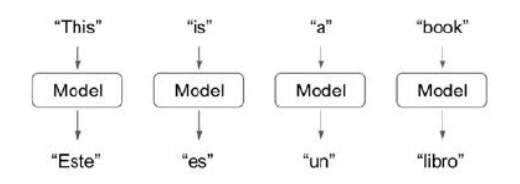

Cependant, nous savons par notre expérience avec le NLP que le langage n'est pas aussi simple que cela ! Des mots simples dans une langue peuvent correspondre à plusieurs mots dans d'autres langues, et l'ordre dans lequel ces mots apparaissent dans une phrase grammaticalement correcte peut ne pas être le même. Par conséquent, nous avons besoin d'un modèle qui peut capturer le contexte d'une phrase entière et produire une traduction correcte, pas un modèle qui vise à traduire directement des mots individuels. C'est là que la modélisation séquence à séquence devient essentielle, comme on le voit ici :

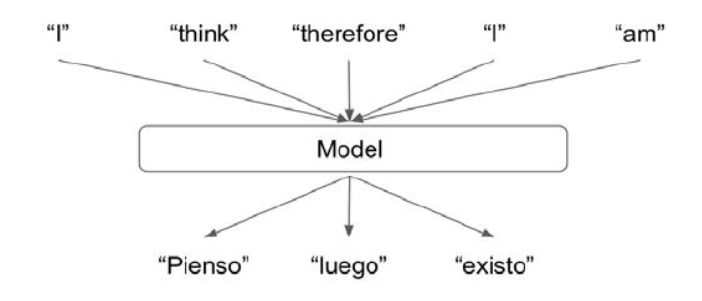

Pour entraîner un modèle séquence à séquence qui capture le contexte de la phrase d'entrée et le traduit en une phrase de sortie, nous allons essentiellement entraîner deux modèles plus petits qui nous permettent de le faire : 

* Un modèle d'encodeur, qui capture le contexte de notre phrase et la génère sous la forme d'un vecteur de contexte unique

* Un décodeur, qui prend la représentation vectorielle de contexte de notre phrase originale et la traduit dans une langue différente.

Donc, en réalité, notre modèle complet de traduction de séquence à séquence ressemblera en fait à ceci :

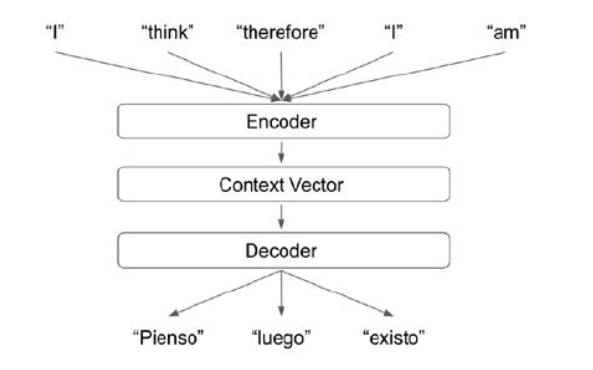

En divisant nos modèles en éléments individuels d'encodeur et de décodeur, nous modularisons eficacement nos modèles. Cela signifie que si nous souhaitons entraîner plusieurs modèles à traduire de l'anglais vers différentes langues, nous n'avons pas besoin de réentraîner l'ensemble du modèle à chaque fois. Nous avons seulement besoin d'entraîner plusieurs décodeurs diférents pour transformer notre vecteur de contexte en nos phrases de sortie. Ensuite, lorsque nous faisons des prédictions, nous pouvons simplement échanger le décodeur que nous souhaitons utiliser pour notre traduction :

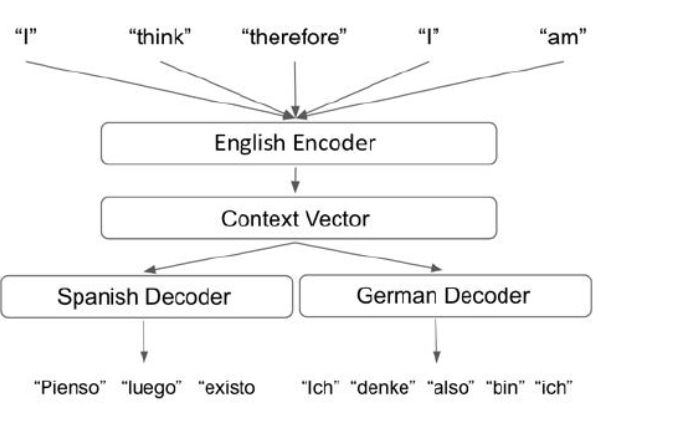

Ensuite, nous examinerons les composants codeur et décodeur du modèle séquence à séquence.

## Encodeurs

Le but de l'élément d'encodeur de notre modèle séquence à séquence est de pouvoir capturer pleinement le contexte de notre phrase d'entrée et de le représenter sous forme de vecteur. Nous pouvons le faire en utilisant des RNN ou, plus précisément, des LSTM. Comme vous vous en souvenez peut-être dans nos guides précédents, les RNN prennent une entrée séquentielle et maintiennent un état caché tout au long de cette séquence. Chaque nouveau mot de la séquence met à jour l'état caché. Ensuite, à la fin de la séquence, nous pouvons utiliser l'état caché final du modèle comme entrée dans notre couche suivante. Dans le cas de notre encodeur, l'état caché représente la représentation vectorielle de contexte de toute notre phrase, ce qui signifie que nous pouvons utiliser la sortie de l'état caché de notre RNN pour représenter l'intégralité de la phrase d'entrée :

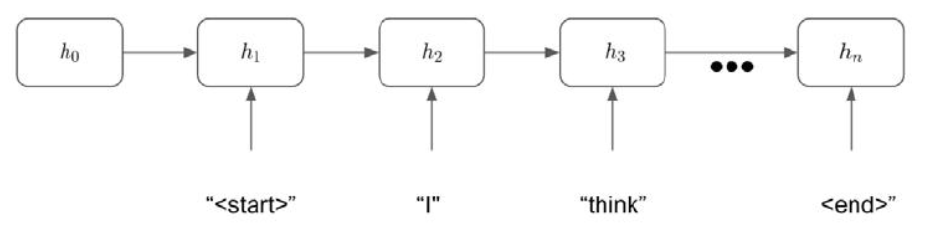

Nous utilisons notre état caché final, hn, comme vecteur de contexte, que nous décoderons ensuite à l'aide d'un décodeur entraîné. Il convient également d'observer que dans le contexte de nos modèles séquence à séquence, nous ajoutons des jetons "start" et "end" au début et à la fin de notre phrase d'entrée, respectivement. C'est parce que nos entrées et sorties n'ont pas une longueur finie et notre modèle doit être capable d'apprendre quand une phrase doit se terminer. Notre phrase d'entrée se terminera toujours par un jeton "end", qui signale à l'encodeur que l'état caché, à ce stade, sera utilisé comme représentation vectorielle de contexte finale pour cette phrase d'entrée. De même, à l'étape du décodeur, nous verrons que notre décodeur continuera à générer des mots jusqu'à ce qu'il prédise un jeton "end". Cela permet à notre décodeur de générer des phrases de sortie réelles, par opposition à une séquence de jetons de longueur infinie. Ensuite, nous verrons comment le décodeur prend ce vecteur de contexte et apprend à le traduire en une phrase de sortie.

## Décodeurs

Notre décodeur prend l'état caché final de notre couche d'encodeur et le décode en une phrase dans une autre langue. Notre décodeur est un RNN, similaire à celui de notre encodeur, mais tandis que notre encodeur met à jour son état caché en fonction de son état caché actuel et du mot actuel dans la phrase, notre décodeur met à jour son état caché et génère un jeton à chaque itération, étant donné le l'état caché actuel et le mot prédit précédent dans la phrase. Cela peut être vu dans le schéma suivant :

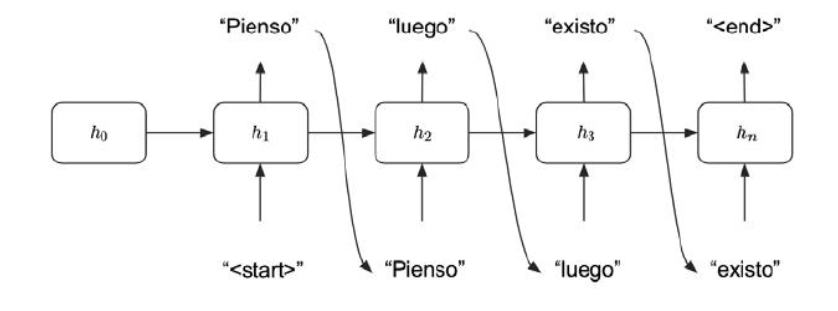

Premièrement, notre modèle prend le vecteur de contexte comme état caché final de notre pas de codeur, h0. Notre modèle vise alors à prédire le mot suivant dans la phrase, étant donné l'état caché actuel, puis le mot précédent dans la phrase. Nous savons que notre phrase doit commencer par un jeton "stat", donc, à notre première étape, notre modèle essaie de prédire le premier mot de la phrase étant donné l'état caché précédent, h0, et le mot précédent de la phrase (dans ce exemple, le jeton "start"). Notre modèle fait une prédiction ("pienso") puis met à jour l'état caché pour refléter le nouvel état du modèle, h1. Ensuite, à l'étape suivante, notre modèle utilise le nouvel état caché et le dernier mot prédit pour prédire le mot suivant dans la phrase. Cela continue jusqu'à ce que le modèle prédise le jeton « end », auquel cas notre modèle arrête de générer des mots de sortie.


L'intuition qui sous-tend ce modèle est conforme à ce que nous avons appris jusqu'à présent sur les représentations linguistiques. Les mots d'une phrase donnée dépendent des mots qui la précèdent. Donc, prédire un mot donné dans une phrase sans tenir compte des mots qui ont été prédits avant cela, cela n'aurait aucun sens car les mots d'une phrase donnée ne sont pas indépendants les uns des autres.


Nous apprenons les paramètres de notre modèle comme nous l'avons fait précédemment : en effectuant une passe avant, en calculant la perte de notre phrase cible par rapport à la phrase prédite, et en rétropropageant cette perte à travers le réseau, en mettant à jour les paramètres au fur et à mesure. Cependant, l'apprentissage à l'aide de ce processus peut être très lent car, au départ, notre modèle aura très peu de pouvoir prédictif. Étant donné que nos prédictions pour les mots de notre phrase cible ne sont pas indépendantes les unes des autres, si nous prédisons le premier mot de notre phrase cible de manière incorrecte, les mots suivants dans notre phrase de sortie sont également peu susceptibles d'être corrects. Pour faciliter ce processus, nous pouvons utiliser une technique connue sous le nom de forçage par l'enseignant(**teacher forcing**).

## teacher forcing

Comme notre modèle ne fait pas de bonnes prédictions au départ, nous constaterons que toutes les erreurs initiales sont multipliées de manière exponentielle. Si notre premier mot prédit dans la phrase est incorrect, le reste de la phrase sera probablement également incorrect. Cela est dû au fait que les prédictions de notre modèle dépendent des prédictions précédentes qu'il fait. Cela signifie que toutes les pertes de notre modèle peuvent être multipliées de façon exponentielle. Pour cette raison, nous pouvons être confrontés au problème du gradient explosif, ce qui rend très difficile pour notre modèle d'apprendre quoi que ce soit :

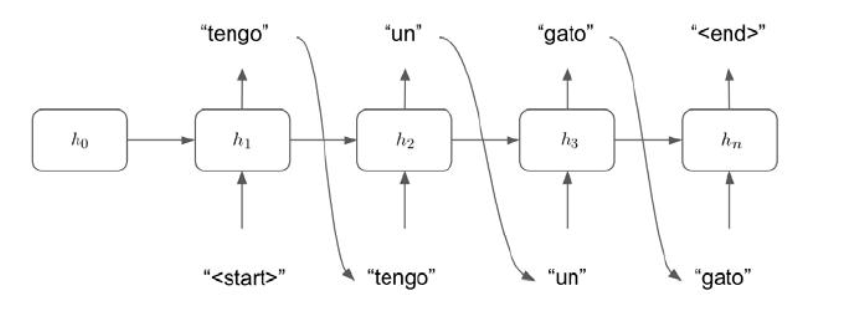

Cependant, en utilisant teacher forcing, nous entraînons notre modèle en utilisant le mot cible précédent correct afin qu'une mauvaise prédiction n'inhibe pas la capacité de notre modèle à apprendre des prédictions correctes. Cela signifie que si notre modèle fait une prédiction incorrecte à un moment donné de la phrase, il peut toujours faire des prédictions correctes en utilisant les mots suivants. Alors que notre modèle aura toujours des mots mal prédits et aura des pertes par lesquelles nous pourrons mettre à jour nos gradients, désormais, nous ne souffrons pas d'explosions de gradients, et notre modèle apprendra beaucoup plus rapidement :

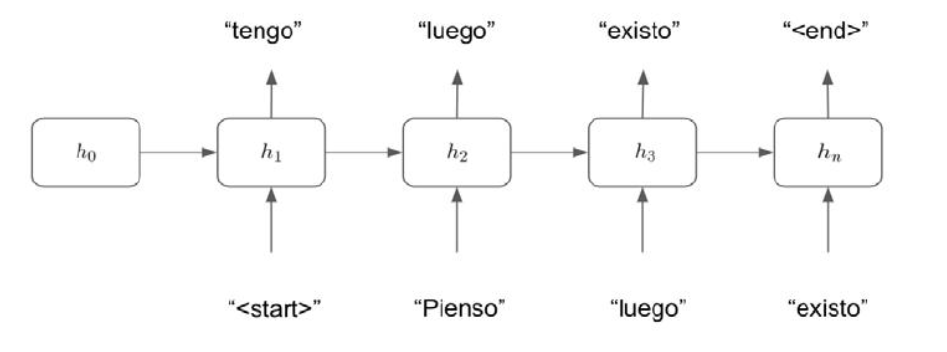

Vous pouvez considérer le forçage par l'enseignant comme un moyen d'aider notre modèle à apprendre indépendamment de ses prédictions précédentes à chaque pas de temps. C'est ainsi que les pertes encourues par une mauvaise prédiction à un pas de temps précoce ne sont pas reportées sur des pas de temps ultérieurs. En combinant les étapes de l'encodeur et du décodeur et en appliquant le forçage de l'enseignant pour aider notre modèle à apprendre, nous pouvons construire une séquence-to-sequence model qui nous permettra de traduire des séquences d'une langue dans une autre. 

Dans la section suivante, nous illustrerons comment nous pouvons construire cela à partir de zéro en utilisant PyTorch.

## Construire un modèle séquence à séquence pour la traduction de texte

Afin de construire notre modèle séquence à séquence pour la traduction, nous allons implémenter le cadre d'encodeur/décodeur que nous avons décrit précédemment. Cela montrera comment les deux moitiés de notre modèle peuvent être utilisées ensemble afin de capturer une représentation de nos données à l'aide de l'encodeur, puis de traduire cette représentation dans une autre langue à l'aide de notre décodeur. Pour ce faire, nous devons obtenir nos données.

## Préparation des données

À l'heure actuelle, nous en savons suffisamment sur l'apprentissage automatique pour savoir que pour une tâche comme celle-ci, nous aurons besoin d'un ensemble de données d'entraînement avec les étiquettes correspondantes. Dans ce cas, nous aurons besoin de phrases dans une langue avec les traductions correspondantes dans une autre langue.

Les données sont un ensemble de plusieurs milliers de paires de traductions de l'anglais vers le français.

Cette question sur Open Data Stack Exchange m'a dirigé vers le site de traduction ouvert https://tatoeba.org/ qui propose des téléchargements sur https://tatoeba.org/eng/downloads - et mieux encore, quelqu'un a fait le travail supplémentaire de fractionnement paires de langues dans des fichiers texte individuels ici : https://www.manythings.org/anki/

Les paires anglais-français sont trop grandes pour être incluses dans le référentiel, alors téléchargez-les dans data/eng-fra.txt. Le fichier est une liste de paires de traductions séparées par des tabulations :

In [1]:
! wget https://download.pytorch.org/tutorial/data.zip

--2021-10-19 07:11:36--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.230.114, 13.226.230.24, 13.226.230.76, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.230.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2021-10-19 07:11:36 (40.7 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [2]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


Nous aurons besoin d'un index unique par mot à utiliser comme entrées et cibles des réseaux plus tard. Pour garder une trace de tout cela, nous utiliserons une classe d'assistance appelée Lang qui a des dictionnaires mot → index (word2index) et index → ​​mot (index2word), ainsi qu'un compte de chaque mot word2count qui sera utilisé pour remplacer les mots rares plus tard.

In [3]:
import unicodedata
import re

Les fichiers sont tous en Unicode, pour simplifier, nous allons transformer les caractères Unicode en ASCII, tout mettre en minuscules et couper la plupart des signes de ponctuation

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Pour lire le fichier de données, nous allons diviser le fichier en lignes, puis diviser les lignes en paires. Les fichiers sont tous anglais → autre langue, donc si nous voulons traduire à partir d'une autre langue → anglais, j'ai ajouté le drapeau inversé pour inverser les paires.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        return pairs
        
    else:
      return pairs

In [6]:
pairs = readLangs("eng", "fra")

Reading lines...


In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
   
    return len(p[0].split()) < MAX_LENGTH and \
        len(p[1].split()) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


pairs = filterPairs(pairs)


In [8]:
import sklearn.model_selection as sms


tauxValid = 0.2
data_train, data_valid = sms.train_test_split(pairs, test_size = tauxValid,random_state=47,shuffle=True)


Ensuite, nous créons une fonction pour chacune de nos langues pour tokeniser nos phrases. 

In [9]:
def tokenize_franch(text):
  return text.split()

def tokenize_english(text):
  return text.split()[::-1]

Avec nos tokenizers construits, nous devons maintenant définir les champs pour notre tokenization. Remarquez ici comment nous ajoutons des jetons de début et de fin à nos séquences afin que notre modèle sache quand commencer et terminer l'entrée et la sortie de la séquence. Nous convertissons également toutes nos phrases d'entrée en minuscules par souci de simplicité

In [10]:
#from torchtext.data import Field, BucketIterator
from torchtext.legacy import data

SOURCE = data.Field(tokenize = tokenize_english, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TARGET = data.Field(tokenize = tokenize_franch, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

datafields = [("text", SOURCE),("label", TARGET)]

In [11]:
# Load data from pd.DataFrame into torchtext.data.Dataset
train_examples = [data.Example.fromlist(i, datafields) for i in data_train]
train_data = data.Dataset(train_examples, datafields)

val_examples = [data.Example.fromlist(i, datafields) for i in data_valid]
valid_data = data.Dataset(val_examples, datafields)

Nous pouvons examiner des phrases individuelles en utilisant la propriété exemples de nos objets de jeu de données. Ici, nous pouvons voir que la propriété source (src) contient notre phrase d'entrée en anglais et que notre cible (trg) contient notre phrase de sortie en francais

In [12]:

print(train_data.examples[0].text)
print(train_data.examples[0].label)

['.', 'die', 'to', 'about', 'is', 'he']
['il', 'est', 'a', 'l', 'article', 'de', 'la', 'mort', '.']


In [13]:

print("Training dataset size: " + str(len(train_data.examples)))
print("Validation dataset size: " + str(len(valid_data.examples)))

Training dataset size: 8479
Validation dataset size: 2120


Maintenant, nous pouvons examiner la taille de chacun de nos ensembles de données. 

In [14]:
SOURCE.build_vocab(train_data, min_freq = 1)
TARGET.build_vocab(train_data, min_freq = 1)

print("English (Source) Vocabulary Size: " + str(len(SOURCE.vocab)))
print("(franch) Vocabulary Size: " + str(len(TARGET.vocab)))

English (Source) Vocabulary Size: 2598
German (franch) Vocabulary Size: 3966


Enfin, nous pouvons créer nos itérateurs de données à partir de nos ensembles de données. Comme nous l'avons fait précédemment, nous spécifions l'utilisation d'un GPU compatible CUDA (s'il est disponible sur notre système) et spécifions notre taille de lot

In [15]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4


train_iterator, valid_iterator = data.BucketIterator.splits(
            (train_data, valid_data),
            batch_size=batch_size,
            sort_key=lambda x: len(x.text),
            shuffle=True)

Le processus complet de préparation des données est le suivant :

* Lire le fichier texte et diviser en lignes, diviser les lignes en paires

* Normaliser le texte, filtrer par longueur et contenu
* Faire des listes de mots à partir de phrases par paires

## Construire l'encodeur


Maintenant, nous sommes prêts à commencer à construire notre encodeur:

* 1. Tout d'abord, nous commençons par initialiser notre modèle en héritant de notre classe nn.Module, comme nous l'avons fait avec tous nos modèles précédents. Nous initialisons avec quelques paramètres, que nous définirons plus tard, ainsi que le nombre de dimensions dans les couches cachées au sein de nos couches LSTM et le nombre de couches LSTM

* 2. Ensuite, nous définissons notre couche d'intégration dans notre encodeur, qui est la longueur du nombre de dimensions d'entrée et la profondeur du nombre de dimensions d'intégration


* 3. Ensuite, nous définissons notre couche LSTM réelle. Cela prend nos phrases imbriquées dans la couche d'intégration, maintient un état caché d'une longueur définie et se compose d'un certain nombre de couches (que nous définirons plus tard comme 2). Nous mettons également en œuvre le décrochage pour appliquer la régularisation à notre réseau

* 4. Ensuite, nous définissons la passe avant dans notre encodeur. Nous appliquons les plongements à nos phrases d'entrée et appliquons dropout. Ensuite, nous passons ces intégrations à travers notre couche LSTM, qui génère notre état caché final. Cela sera utilisé par notre décodeur pour former notre phrase traduite

Nos encodeurs seront constitués de deux couches LSTM, ce qui signifie que notre sortie produira deux états cachés. Cela signifie également que notre couche LSTM complète, ainsi que notre encodeur, ressemblera à quelque chose comme ceci, avec notre modèle produisant deux états cachés :

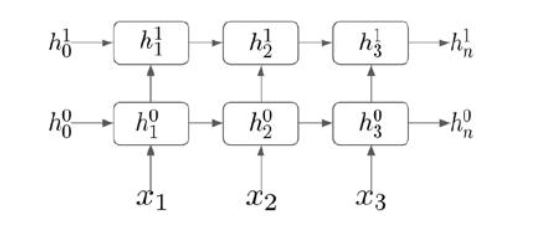

In [26]:

from torch import nn
import random


class Encoder(nn.Module):
    def __init__(self, input_dims, emb_dims, hid_dims, n_layers, dropout):
        super().__init__()
        
        self.hid_dims = hid_dims
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dims, emb_dims)
        
        self.rnn = nn.LSTM(emb_dims, hid_dims, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        embedded = self.dropout(self.embedding(src))
        
        outputs, (h, cell) = self.rnn(embedded)
        
        return h, cell

## Construire le décodeur

Notre décodeur prendra les états cachés finaux de la couche LSTM de notre encodeur et les traduira en une phrase de sortie dans une autre langue. Nous commençons par initialiser notre décodeur presque exactement de la même manière que nous l'avons fait pour l'encodeur. La seule différence ici est que nous ajoutons également une couche linéaire entièrement connectée. Cette couche utilisera les états cachés finaux de notre LSTM afin de faire des prédictions concernant le mot correct dans la phrase.

Notre passe avant est similaire à celle de notre encodeur, à l'exception de l'ajout de deux étapes clés. Nous décompressons d'abord notre entrée de la couche précédente afin qu'elle soit de la bonne taille pour l'entrée dans notre couche d'intégration. Nous ajoutons également une couche entièrement connectée, qui prend la couche cachée de sortie de nos couches RNN et l'utilise pour faire une prédiction concernant le mot suivant dans la séquence.

Encore une fois, comme pour notre encodeur, nous utilisons une couche LSTM à deux couches dans notre décodeur. Nous prenons notre état caché final de nos encodeurs et les utilisons pour générer le premier mot de notre séquence, Y1. Nous mettons ensuite à jour notre état caché et utilisons ceci et Y1 pour générer notre prochain mot, Y2, en répétant ce processus jusqu'à ce que notre modèle génère un jeton de fin. Notre décodeur ressemble à ceci

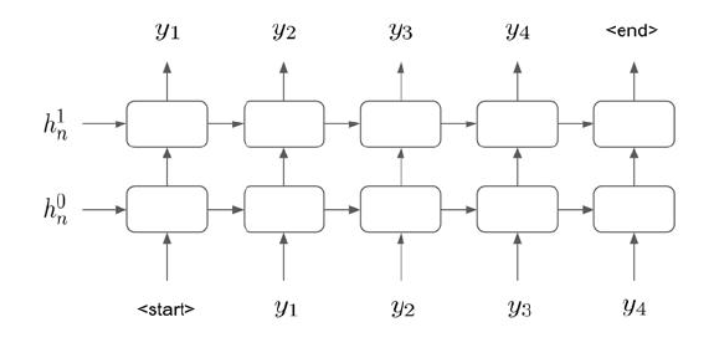

Ici, on voit que définir les encodeurs et décodeurs individuellement n'est pas particulièrement compliqué. Cependant, lorsque nous combinons ces étapes dans un modèle séquence à séquence plus large, les choses commencent à devenir intéressantes.

In [17]:
class Decoder(nn.Module):
    def __init__(self, output_dims, emb_dims, hid_dims, n_layers, dropout):
        super().__init__()
        
        self.output_dims = output_dims
        self.hid_dims = hid_dims
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dims, emb_dims)
        
        self.rnn = nn.LSTM(emb_dims, hid_dims, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dims, output_dims)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, h, cell):
                
        input = input.unsqueeze(0)
                
        embedded = self.dropout(self.embedding(input))
                
        output, (h, cell) = self.rnn(embedded, (h, cell))
        
        pred = self.fc_out(output.squeeze(0))
        
        return pred, h, cell

## Construire le modèle complet séquence à séquence

Nous devons maintenant assembler les deux moitiés de notre modèle pour produire le modèle complet séquence à séquence:

* 1. Nous commençons par créer une nouvelle classe séquence à séquence. Cela nous permettra de lui passer notre encodeur et décodeur comme arguments

2. Ensuite, nous créons la méthode forward dans notre classe Seq2Seq. C'est sans doute la partie la plus compliquée du modèle. Nous combinons notre encodeur avec notre décodeur et utilisons le forçage de l'enseignant pour aider notre modèle à apprendre. On commence par créer un tenseur dans lequel on stocke encore nos prédictions. Nous initialisons cela comme un tenseur plein de zéros, mais nous le mettons toujours à jour avec nos prédictions au fur et à mesure que nous les faisons. La forme de notre tenseur de zéros sera la longueur de notre phrase cible, la largeur de notre taille de lot et la profondeur de notre taille de vocabulaire cible (allemand).

* 3. Ensuite, nous introduisons notre phrase d'entrée dans notre encodeur pour obtenir les états cachés de sortie.

* 4. Ensuite, nous devons parcourir notre modèle de décodeur pour générer une prédiction de sortie pour chaque étape de notre séquence de sortie. Le premier élément de notre séquence de sortie sera toujours le jeton <start>. Nos séquences cibles contiennent déjà ceci en tant que premier élément, nous définissons donc simplement notre entrée initiale égale à ceci en prenant le premier élément de la liste

* 5. Ensuite, nous parcourons et faisons nos prédictions. Nous passons nos états cachés (de la sortie de notre encodeur) à notre décodeur, ainsi que notre entrée initiale (qui n'est que le jeton <start>). Cela renvoie une prédiction pour tous les mots de notre séquence. Cependant, nous ne sommes intéressés que par le mot au sein de notre étape actuelle ; c'est-à-dire le mot suivant dans la séquence. Notez comment nous commençons notre boucle à partir de 1 au lieu de 0, donc notre première prédiction est le deuxième mot de la séquence (car le premier mot qui est prédit sera toujours le jeton de départ).

* 6. Cette sortie consiste en un vecteur de la longueur du vocabulaire cible, avec une prédiction pour chaque mot du vocabulaire. Nous prenons la fonction argmax pour identifier le mot réel qui est prédit par le modèle

Nous devons ensuite sélectionner notre nouvelle entrée pour l'étape suivante. Nous définissons notre ratio de forçage enseignant à 50%, ce qui signifie que 50% du temps, nous utiliserons la prédiction que nous venons de faire comme prochaine entrée dans notre décodeur et que les 50% restants, nous prendrons la véritable cible . Comme nous l'avons vu précédemment, cela aide notre modèle à apprendre beaucoup plus rapidement que de se fier uniquement aux prédictions du modèle. Nous poursuivons ensuite cette boucle jusqu'à ce que nous ayons une prédiction complète pour chaque mot de la séquence.

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_rate = 0.5):
        
        batch_size = trg.shape[1]
        target_length = trg.shape[0]
        target_vocab_size = self.decoder.output_dims
        
        outputs = torch.zeros(target_length, batch_size, target_vocab_size).to(self.device)
        
        h, cell = self.encoder(src)
        
        input = trg[0,:]
        
        for t in range(1, target_length):

            output, h, cell = self.decoder(input, h, cell)
            
            outputs[t] = output
            
            top = output.argmax(1) 
        
            input = trg[t] if (random.random() < teacher_forcing_rate) else top
        
        return outputs

* 7. Enfin, nous créons une instance de notre modèle Seq2Seq prête à être entraînée. Nous initialisons un encodeur et un décodeur avec une sélection d'hyperparamètres, qui peuvent tous être modifiés pour modifier légèrement le modèle :

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dimensions = len(SOURCE.vocab)
output_dimensions = len(TARGET.vocab)

encoder_embedding_dimensions = 256
decoder_embedding_dimensions = 256
hidden_layer_dimensions = 512
number_of_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5

encod = Encoder(input_dimensions, encoder_embedding_dimensions,\
              hidden_layer_dimensions, number_of_layers, encoder_dropout)

decod = Decoder(output_dimensions, decoder_embedding_dimensions,\
              hidden_layer_dimensions, number_of_layers, decoder_dropout)


model = Seq2Seq(encod, decod, device).to(device)


Essayez ici d'expérimenter avec différents paramètres et voyez comment cela affecte les performances du modèle. Par exemple, le fait d'avoir un plus grand nombre de dimensions dans vos couches cachées peut ralentir l'entraînement du modèle, bien que les performances finales globales du modèle puissent être meilleures. Alternativement, le modèle peut déborder. Souvent, il s'agit d'expérimenter pour trouver le modèle le plus performant. Après avoir entièrement défini notre modèle Seq2Seq, nous sommes maintenant prêts à commencer à l'entraîner.

## Entraînement de modèle.

Notre modèle sera initialisé avec des poids de 0 dans toutes les parties du modèle. Alors que le modèle devrait théoriquement être capable d'apprendre sans poids (zéro), il a été démontré que l'initialisation avec des poids aléatoires peut aider le modèle à apprendre plus rapidement. Commençons.

* 1.  Ici, nous allons initialiser notre modèle avec les poids d'échantillons aléatoires d'une distribution normale, les valeurs étant comprises entre -0,1 et 0,1



In [20]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.1, 0.1)
        
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2598, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3966, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=3966, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

* 2. Ensuite, comme pour tous nos autres modèles, nous définissons nos fonctions d'optimisation et de perte. Nous utilisons la perte d'entropie croisée car nous effectuons une classification multi-classe (par opposition à la perte d'entropie croisée binaire pour une classification binaire)

In [21]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = TARGET.vocab.stoi[TARGET.pad_token])

* 3. Ensuite, nous définissons le processus d'apprentissage dans une fonction appelée train(). Tout d'abord, nous définissons notre modèle en mode d'entraînement et définissons la perte d'époque sur 0

Nous parcourons ensuite chaque lot dans notre itérateur d'entraînement et extrayons la phrase à traduire (src) et la traduction correcte de cette phrase (trg). Nous mettons ensuite à zéro nos gradients (pour éviter l'accumulation de gradients) et calculons la sortie de notre modèle en passant notre fonction de modèle à nos entrées et sorties

Ensuite, nous devons calculer la perte de la prédiction de notre modèle en comparant notre sortie prédite à la phrase traduite vraie et correcte. Nous remodelons nos données de sortie et nos données cibles à l'aide des fonctions de forme et de vue afin de créer deux tenseurs pouvant être comparés pour calculer la perte. Nous calculons le critère de perte entre nos tenseurs de sortie et trg, puis rétropropageons cette perte à travers le réseau

In [22]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.text
        trg = batch.label
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        output_dims = output.shape[-1]
        output = output[1:].view(-1, output_dims)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.text
            trg = batch.label
            output = model(src, trg, 0)

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
import time
import numpy as np
import random
epochs = 20
grad_clip = 1

lowest_validation_loss = float('inf')

for epoch in range(epochs):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, grad_clip)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    if valid_loss < lowest_validation_loss:
        lowest_validation_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {np.round(end_time-start_time,0)}s')
    print(f'\tTrain Loss: {train_loss:.4f}')
    print(f'\t Val. Loss: {valid_loss:.4f}')

Epoch: 01 | Time: 753.0s
	Train Loss: 3.6201
	 Val. Loss: 3.3217
Epoch: 02 | Time: 771.0s
	Train Loss: 2.8698
	 Val. Loss: 3.0725
Epoch: 03 | Time: 766.0s
	Train Loss: 2.4833
	 Val. Loss: 2.9358
Epoch: 04 | Time: 762.0s
	Train Loss: 2.1852
	 Val. Loss: 2.8978
Epoch: 05 | Time: 756.0s
	Train Loss: 1.9357
	 Val. Loss: 2.8224
Epoch: 06 | Time: 757.0s
	Train Loss: 1.7373
	 Val. Loss: 2.8042
Epoch: 07 | Time: 759.0s
	Train Loss: 1.5483
	 Val. Loss: 2.8049
Epoch: 08 | Time: 798.0s
	Train Loss: 1.3870
	 Val. Loss: 2.7787
Epoch: 09 | Time: 781.0s
	Train Loss: 1.2635
	 Val. Loss: 2.7182
Epoch: 10 | Time: 774.0s
	Train Loss: 1.1452
	 Val. Loss: 2.7632
Epoch: 11 | Time: 770.0s
	Train Loss: 1.0512
	 Val. Loss: 2.7808
Epoch: 12 | Time: 782.0s
	Train Loss: 0.9635
	 Val. Loss: 2.7939
Epoch: 13 | Time: 802.0s
	Train Loss: 0.8938
	 Val. Loss: 2.8169
Epoch: 14 | Time: 790.0s
	Train Loss: 0.8323
	 Val. Loss: 2.8555
Epoch: 15 | Time: 799.0s
	Train Loss: 0.7842
	 Val. Loss: 2.8263
Epoch: 16 | Time: 832.0s


In [27]:
model.load_state_dict(torch.load('seq2seq.pt'))

test_loss = evaluate(model, valid_iterator, criterion)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 2.7182


In [31]:
def translate(model, iterator, limit = 4):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            if i < limit :
                
                src = batch.text
                trg = batch.label

                output = model(src, trg, 0)
                preds = torch.tensor([[torch.argmax(x).item()] for x in output])
                
                print('English Input: ' + str([SOURCE.vocab.itos[x] for x in src][1:-1][::-1]))
                print('Correct franch Output: ' + str([TARGET.vocab.itos[x] for x in trg][1:-1]))
                print('Predicted franch Output: ' + str([TARGET.vocab.itos[x] for x in preds][1:-1]))
                print('\n')

In [32]:

batch_size = 1


train_iterator, valid_iterator = data.BucketIterator.splits(
            (train_data, valid_data),
            batch_size=batch_size,
            sort_key=lambda x: len(x.text),
            shuffle=True)

In [39]:
output = translate(model, train_iterator, limit = 10)

English Input: ['he', 'is', 'one', 'of', 'my', 'neighbours', '.']
Correct franch Output: ['c', 'est', 'l', 'un', 'de', 'mes', 'voisins', '.']
Predicted franch Output: ['c', 'est', 'un', 'de', 'mes', 'voisins', '.', '<eos>']


English Input: ['he', 's', 'love', 'struck', '.']
Correct franch Output: ['il', 'a', 'le', 'coup', 'de', 'foudre', '.']
Predicted franch Output: ['il', 'a', 'des', 'cinquante', '.', 'foudre', '.']


English Input: ['i', 'm', 'too', 'sleepy', 'to', 'drive', '.']
Correct franch Output: ['je', 'suis', 'trop', 'somnolent', 'pour', 'conduire', '.']
Predicted franch Output: ['je', 'suis', 'trop', 'somnolent', 'pour', 'conduire', '.']


English Input: ['i', 'm', 'not', 'on', 'duty', 'today', '.']
Correct franch Output: ['je', 'ne', 'suis', 'pas', 'en', 'service', 'aujourd', 'hui', '.']
Predicted franch Output: ['je', 'ne', 'suis', 'pas', 'du', 'service', 'aujourd', 'hui', '.']


English Input: ['he', 's', 'right', 'behind', 'you', '.']
Correct franch Output: ['il', 'est'